# 🎬 **Sentimental Analysis Pada Ulasan Film IMDb Menggunakan Klasifikasi Naive-Bayes**

Proyek ini mendemonstrasikan cara membangun model **Analisis Sentimen** menggunakan **Naive Bayes Classifier** pada dataset ulasan film IMDB yang populer. Tujuannya adalah untuk mengklasifikasikan ulasan sebagai **positif** atau **negatif** berdasarkan konten tekstualnya.

Kami akan membahasnya:
- Mempersiapkan data teks
- Membuat vektor teks menggunakan TF-IDF
- Melatih pengklasifikasi Naive Bayes
- Mengevaluasi model

### Understanding the Data

In [1]:
# Import library:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import data dari lokal:
df = pd.read_csv(r'C:\Users\ilham\Documents\Portfolio\AI\Naive Bayes-Sentiment Analysis IMDb Movie\IMDB_Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Cek informasi dalam dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
# Melihat ringkasan statistik dari data
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Exploratory Data Analysis

In [5]:
# Jumlah sentimen: 
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

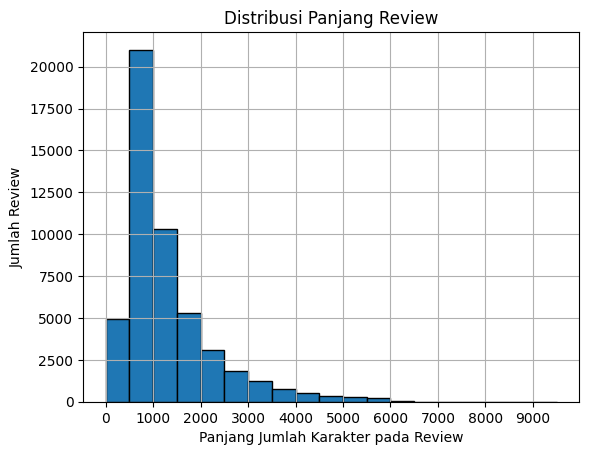

In [6]:
# Persebaran panjang karakter pada review
# Membuat histogram dengan rentang per 500 karakter
df['review'].str.len().hist(bins=range(0, 10000, 500), edgecolor='black')

plt.title('Distribusi Panjang Review')
plt.xlabel('Panjang Jumlah Karakter pada Review')
plt.ylabel('Jumlah Review')

plt.xticks(range(0, 10000, 1000))
plt.show()

Grafik menunjukkan bahwa panjang ulasan berkisar antara 10 sampai kurang dari 10.000 karakter, dengan sebagian besar berada dalam rentang 500 hingga 1.000 karakter. Hal ini menunjukkan bahwa mayoritas pengguna cenderung menulis ulasan yang singkat.

Sekarang, untuk mendapatkan insight lebih lanjut, kita akan menganalisis distribusi panjang ulasan secara terpisah untuk ulasan positif dan negatif guna melihat apakah ada perbedaan pola yang signifikan

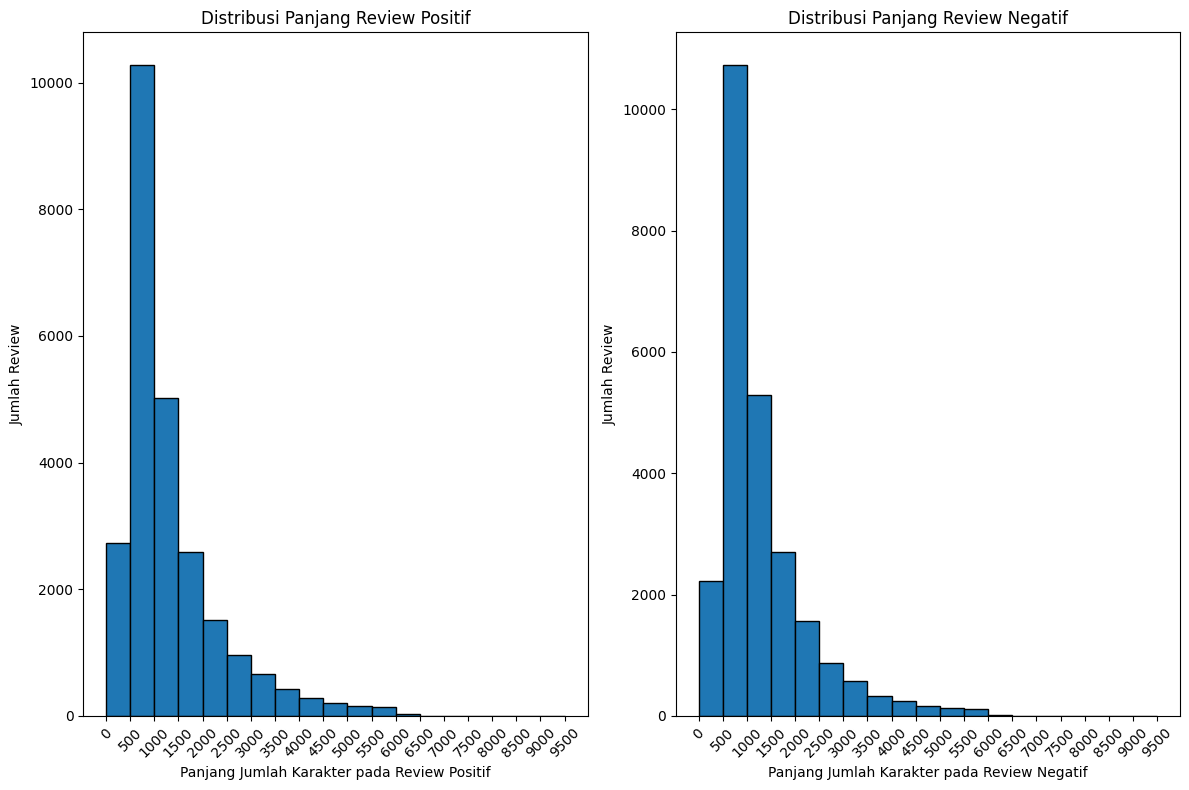

In [7]:
# Persebaran panjang karakter review berdasarkan sentimen
# Membuat histogram dengan rentang per 500 karakter
bins = range(0, 10000, 500)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Histogram review positif
ax1.hist(df[df['sentiment'] == 'positive']['review'].str.len(), bins=bins, edgecolor='black')
ax1.set_title('Distribusi Panjang Review Positif')
ax1.set_xlabel('Panjang Jumlah Karakter pada Review Positif')
ax1.set_ylabel('Jumlah Review')
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.set_xticks(bins)

# Histogram review negatif
ax2.hist(df[df['sentiment'] == 'negative']['review'].str.len(), bins=bins, edgecolor='black')
ax2.set_title('Distribusi Panjang Review Negatif')
ax2.set_xlabel('Panjang Jumlah Karakter pada Review Negatif')
ax2.set_ylabel('Jumlah Review')
plt.setp(ax2.get_xticklabels(), rotation=45)
ax2.set_xticks(bins)

plt.tight_layout()
plt.show()

Dari grafik diatas menunjukkan bahwa, ulasan positif cenderung lebih singkat dibandingkan ulasan negatif. Namun, rentang panjang karakter ulasan positif lebih besar, yang menunjukkan bahwa dalam beberapa kasus, orang memberikan ulasan yang sangat panjang untuk film yang dianggap luar biasa. Sebaliknya, kritik terhadap film yang buruk cenderung lebih ringkas.

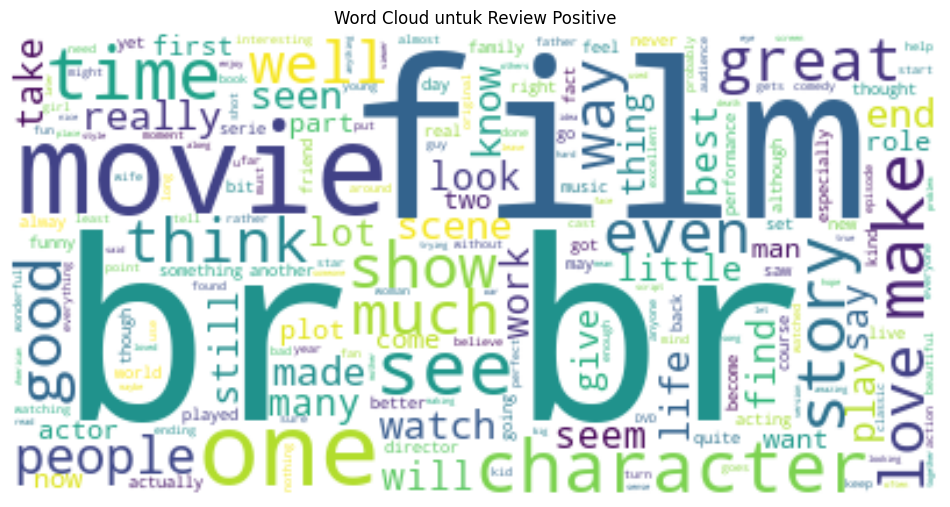

In [8]:
# Menampilkan grafik wordcloud untuk menunjukkan kata-kata POSITIF yang paling sering digunakan
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

positive_text = " ".join(i for i in df[df['sentiment'] == 'positive']['review'])
positive_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive_text)

plt.figure( figsize=(12,8))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud untuk Review Positive")
plt.show()

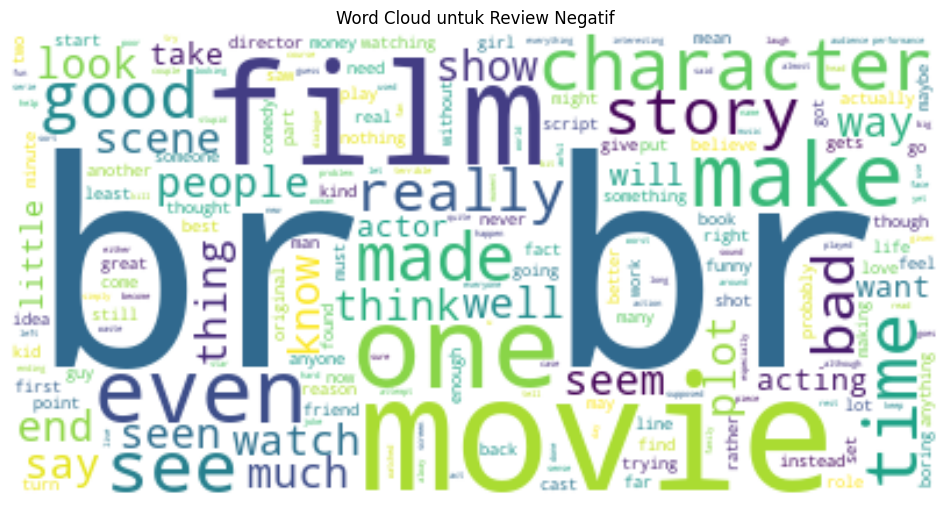

In [9]:
# Menampilkan grafik wordcloud untuk menunjukkan kata-kata NEGATIF yang paling sering digunakan
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

negative_text = " ".join(i for i in df[df['sentiment'] == 'negative']['review'])
negative_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(negative_text)

plt.figure( figsize=(12,8))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud untuk Review Negatif")
plt.show()


Grafik wordcloud pada komentar positif dan negatif tidak menunjukkan hasil yang berarti.

Itulah alasan mengapa preprocessing teks diperlukan.

### Preprocessing Data

In [10]:
df.rename(columns={'review':'text'}, inplace = True)
df

,text,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [11]:
import re
import string

# Membersihkan data seperti mengubah ke lowercase, menghapus link dan spesial karakter, dan punctuation
def cleaning(text):        
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"\b\d+\b", "", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
    
# Menghapus emoticon
    emoji_pattern = re.compile("[" 
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

# Menghapus kata singkat
    text = re.sub("isn't",'is not',text)
    text = re.sub("he's",'he is',text)
    text = re.sub("wasn't",'was not',text)
    text = re.sub("there's",'there is',text)
    text = re.sub("couldn't",'could not',text)
    text = re.sub("won't",'will not',text)
    text = re.sub("they're",'they are',text)
    text = re.sub("she's",'she is',text)
    text = re.sub("There's",'there is',text)
    text = re.sub("wouldn't",'would not',text)
    text = re.sub("haven't",'have not',text)
    text = re.sub("That's",'That is',text)
    text = re.sub("you've",'you have',text)
    text = re.sub("He's",'He is',text)
    text = re.sub("what's",'what is',text)
    text = re.sub("weren't",'were not',text)
    text = re.sub("we're",'we are',text)
    text = re.sub("hasn't",'has not',text)
    text = re.sub("you'd",'you would',text)
    text = re.sub("shouldn't",'should not',text)
    text = re.sub("let's",'let us',text)
    text = re.sub("they've",'they have',text)
    text = re.sub("You'll",'You will',text)
    text = re.sub("i'm",'i am',text)
    text = re.sub("we've",'we have',text)
    text = re.sub("it's",'it is',text)
    text = re.sub("don't",'do not',text)
    text = re.sub("that´s",'that is',text)
    text = re.sub("I´m",'I am',text)
    text = re.sub("it’s",'it is',text)
    text = re.sub("she´s",'she is',text)
    text = re.sub("he’s'",'he is',text)
    text = re.sub('I’m','I am',text)
    text = re.sub('I’d','I did',text)
    text = re.sub("he’s'",'he is',text)
    text = re.sub('there’s','there is',text)
    
    return text

dt = df['text'].apply(cleaning)


In [12]:
df['sentiment']

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

In [13]:
dt = pd.DataFrame(dt)  
dt['sentiment']=df['sentiment']
dt

,text,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,im going to have to disagree with the previous...,negative


In [14]:
import nltk
from nltk.corpus import stopwords

# Menghapus stop word
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
dt['no_sw'] = dt['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
dt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ilham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,sentiment,no_sw
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...
1,a wonderful little production the filming tech...,positive,wonderful little production filming technique ...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,basically theres a family where a little boy j...,negative,basically theres family little boy jake thinks...
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...
...,...,...,...
49995,i thought this movie did a down right good job...,positive,thought movie right good job wasnt creative or...
49996,bad plot bad dialogue bad acting idiotic direc...,negative,bad plot bad dialogue bad acting idiotic direc...
49997,i am a catholic taught in parochial elementary...,negative,catholic taught parochial elementary schools n...
49998,im going to have to disagree with the previous...,negative,im going disagree previous comment side maltin...


In [15]:
from collections import Counter

# Melihat 10 kata yang paling sering muncul
cnt = Counter()
for text in dt["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp

,word,count
0,movie,83576
1,film,74511
2,one,50392
3,like,38833
4,good,28502
5,even,24283
6,would,24001
7,time,23298
8,really,22900
9,see,22437


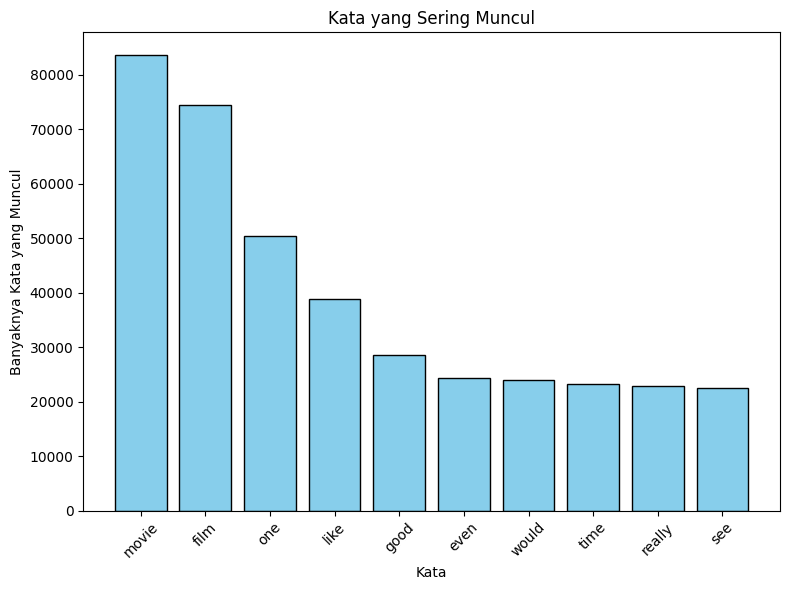

In [16]:
plt.figure(figsize=(8, 6))
plt.bar(temp['word'], temp['count'], color='skyblue', edgecolor='black')
plt.title('Kata yang Sering Muncul')
plt.xlabel('Kata')
plt.ylabel('Banyaknya Kata yang Muncul')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
from collections import Counter

# Hitung jumlah kata
cnt = Counter()
for text in dt["no_sw"]:
    for word in text.split():
        cnt[word] += 1

# Ambil 10 kata yang paling sering muncul
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
dt["wo_stopfreq"] = dt["no_sw"].apply(remove_freqwords)
dt.head()

,text,sentiment,no_sw,wo_stopfreq
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...,reviewers mentioned watching oz episode youll ...
1,a wonderful little production the filming tech...,positive,wonderful little production filming technique ...,wonderful little production filming technique ...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend hot summer weekend...
3,basically theres a family where a little boy j...,negative,basically theres family little boy jake thinks...,basically theres family little boy jake thinks...
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...,petter matteis love money visually stunning wa...


In [18]:
dt['no_sw'].loc[5]

'probably alltime favorite movie story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance brings tears eyes bette davis one truly sympathetic roles delight kids grandma says like dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd movie'

In [19]:
dt['wo_stopfreq'].loc[5]

'probably alltime favorite story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance brings tears eyes bette davis truly sympathetic roles delight kids grandma says dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd'

In [20]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
wordnet_lem = WordNetLemmatizer()

# Menerapkan lemmatization untuk semua kata dalam tiap baris
dt['wo_stopfreq_lem'] = dt['wo_stopfreq'].apply(
    lambda x: " ".join([wordnet_lem.lemmatize(word) for word in x.split()])
)
dt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ilham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,sentiment,no_sw,wo_stopfreq,wo_stopfreq_lem
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...,reviewers mentioned watching oz episode youll ...,reviewer mentioned watching oz episode youll h...
1,a wonderful little production the filming tech...,positive,wonderful little production filming technique ...,wonderful little production filming technique ...,wonderful little production filming technique ...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend hot summer weekend...,thought wonderful way spend hot summer weekend...
3,basically theres a family where a little boy j...,negative,basically theres family little boy jake thinks...,basically theres family little boy jake thinks...,basically there family little boy jake think t...
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...,petter matteis love money visually stunning wa...,petter matteis love money visually stunning wa...
...,...,...,...,...,...
49995,i thought this movie did a down right good job...,positive,thought movie right good job wasnt creative or...,thought right job wasnt creative original firs...,thought right job wasnt creative original firs...
49996,bad plot bad dialogue bad acting idiotic direc...,negative,bad plot bad dialogue bad acting idiotic direc...,bad plot bad dialogue bad acting idiotic direc...,bad plot bad dialogue bad acting idiotic direc...
49997,i am a catholic taught in parochial elementary...,negative,catholic taught parochial elementary schools n...,catholic taught parochial elementary schools n...,catholic taught parochial elementary school nu...
49998,im going to have to disagree with the previous...,negative,im going disagree previous comment side maltin...,im going disagree previous comment side maltin...,im going disagree previous comment side maltin...


### Tokenization

In [21]:
# Membuat data yang sudah di proses untuk train-test split
nb=dt.drop(columns=['text','no_sw', 'wo_stopfreq'])
nb.columns=['sentiment','review']
nb.sentiment = [0 if each == "negative" else 1 for each in nb.sentiment]
nb

,sentiment,review
0,1,reviewer mentioned watching oz episode youll h...
1,1,wonderful little production filming technique ...
2,1,thought wonderful way spend hot summer weekend...
3,0,basically there family little boy jake think t...
4,1,petter matteis love money visually stunning wa...
...,...,...
49995,1,thought right job wasnt creative original firs...
49996,0,bad plot bad dialogue bad acting idiotic direc...
49997,0,catholic taught parochial elementary school nu...
49998,0,im going disagree previous comment side maltin...


In [22]:
tokenized_review=nb['review'].apply(lambda x: x.split())
tokenized_review.head(5)

0    [reviewer, mentioned, watching, oz, episode, y...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, hot, summer, ...
3    [basically, there, family, little, boy, jake, ...
4    [petter, matteis, love, money, visually, stunn...
Name: review, dtype: object

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), tokenizer=token.tokenize)
text_counts = cv.fit_transform(nb['review'])

c:\Users\ilham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Train-Test Split

In [24]:
from sklearn.model_selection import train_test_split
X = text_counts
y = nb['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)

### Naive Bayes Modelling

#### 1. Complement Naive Bayes model

In [25]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix

CNB = ComplementNB()
CNB.fit(X_train, y_train)

from sklearn import metrics
predicted = CNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))


ComplementNB model accuracy is 86.21%
------------------------------------------------
Confusion Matrix:
      0     1
0  4345   632
1   747  4276
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4977
           1       0.87      0.85      0.86      5023

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



✅ Accuracy score:  
Model Complement Naive Bayes memiliki akurasi sebesar 86.21%. Artinya, dari 100 prediksi yang dilakukan, rata-rata 86 prediksi berhasil diklasifikasikan dengan benar oleh model.

🔢 Confusion Matrix:
- True Negative (TN): Sebanyak 4345 ulasan negatif berhasil diprediksi sebagai negatif oleh model.    
- True Positive (TP): Sebanyak 4276 ulasan positif berhasil diprediksi sebagai positif oleh model.    
- False Positive (FP): Sebanyak 632 ulasan positif diprediksi sebagai negatif oleh model.     
- False Negative (FN): Sebanyak 747 ulasan negatif diprediksi sebagai positif oleh model. 

📊 Classification Report:   
🎯 Precision:
- Negative review (kelas 0): rasio ulasan negatif yang diprediksi dengan benar terhadap seluruh prediksi negatif adalah 0.85  
- Positive review (kelas 1): rasio ulasan positif yang diprediksi dengan benar terhadap seluruh prediksi positif adalah 0.87  

🧠 Recall:
- Negative review: rasio ulasan negatif yang diprediksi dengan benar terhadap seluruh ulasan negatif aktual adalah 0.87   
- Positive review: rasio ulasan positif yang diprediksi dengan benar terhadap seluruh ulasan positif aktual adalah 0.85   

⚖️ F1 Score:   
F1 Score adalah rata-rata harmonis dari precision dan recall. Pada kedua kelas (positif dan negatif), nilai F1 Score adalah 0.86, menunjukkan performa yang seimbang dalam hal presisi dan sensitivitas.

#### 2. Mutilnominal Naive Bayes model

In [26]:
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, y_train)

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

MultinominalNB model accuracy is 86.20%
------------------------------------------------
Confusion Matrix:
      0     1
0  4345   632
1   748  4275
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4977
           1       0.87      0.85      0.86      5023

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



✅ Accuracy Score   
Mendapat Accuracy score sebesar 86.20% untuk model MultinomialNB. Artinya, dari setiap 100 prediksi, rata-rata model ini mampu memprediksi dengan benar sekitar 86 kasus.

🔢 Confusion Matrix:
- True Negative (TN): Model memprediksi 4345 ulasan sebagai negatif, dan memang benar ulasan itu negatif. 
- True Positive (TP): Model memprediksi 4275 ulasan sebagai positif, dan memang benar ulasan itu positif. 
- False Positive (FP): Model memprediksi 632 ulasan sebagai positif, padahal sebenarnya negatif.  
- False Negative (FN): Model memprediksi 748 ulasan sebagai negatif, padahal sebenarnya positif.

📊 Classification Report:   
🎯 Precision:
- Negatif review: Rasio ulasan negatif yang benar-benar negatif terhadap semua prediksi negatif adalah 0.85.  
- Positif review: Rasio ulasan positif yang benar-benar positif terhadap semua prediksi positif adalah 0.87.

🧠 Recall:
- Negatif review: Rasio ulasan negatif yang benar-benar terdeteksi sebagai negatif dari seluruh ulasan negatif yang ada adalah 0.87.  
- Positif review: Rasio ulasan positif yang benar-benar terdeteksi sebagai positif dari seluruh ulasan positif yang ada adalah 0.85.

⚖️ F1-Score:    
F1 Score adalah rata-rata harmonis dari precision dan recall. Untuk kedua kelas (positif dan negatif), F1 Score = 0.86, menunjukkan keseimbangan antara precision dan recall yang baik.

#### 3. Bernoulli Naive Bayes model

In [27]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

predicted = BNB.predict(X_test)
accuracy_score_bnb = metrics.accuracy_score(predicted,y_test)

print('BernoulliNB model accuracy = ' + str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

BernoulliNB model accuracy = 84.93%
------------------------------------------------
Confusion Matrix:
      0     1
0  4387   590
1   917  4106
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      4977
           1       0.87      0.82      0.84      5023

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



✅ Accuracy Score   
Accuracy score adalah 84.93% untuk model BernoulliNB. Artinya, dari setiap 100 prediksi, model ini mampu memprediksi dengan benar sekitar 85 kasus.

🔢 Confusion Matrix:    
- True Negative (TN): Model memprediksi 4387 ulasan sebagai negatif, dan memang benar ulasan itu negatif. 
- True Positive (TP): Model memprediksi 4106 ulasan sebagai positif, dan memang benar ulasan itu positif. 
- False Positive (FP): Model memprediksi 590 ulasan sebagai positif, padahal sebenarnya negatif.  
- False Negative (FN): Model memprediksi 917 ulasan sebagai negatif, padahal sebenarnya positif.

📊 Classification Report:   
🎯 Precision:   
- Negatif review: Hanya 83% dari prediksi negatif yang benar-benar negatif.   
- Positif review: 87% dari prediksi positif benar-benar positif.

🧠 Recall:  
- Negatif review: Dari semua ulasan negatif yang ada, model berhasil menangkap 88% dengan benar.  
- Positif review: Dari semua ulasan positif, model berhasil mengidentifikasi 82% dengan benar.

⚖️ F1-Score:    
F1 Score untuk negatif: 0.85, dan positif: 0.84, menunjukkan performa yang cukup baik namun sedikit kurang seimbang dibanding model lainnya.

#### Plot Confusion Matrices

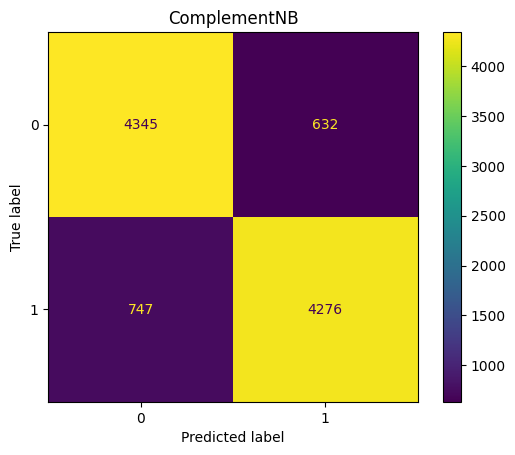

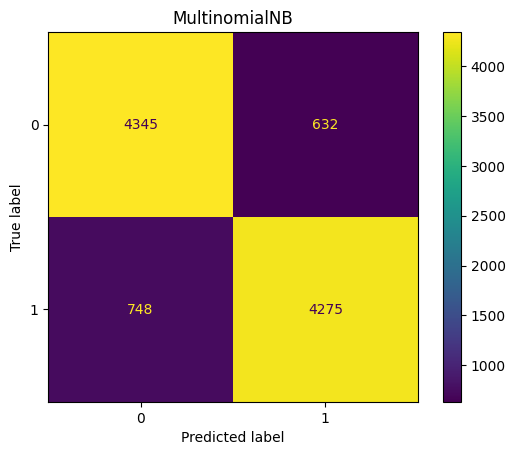

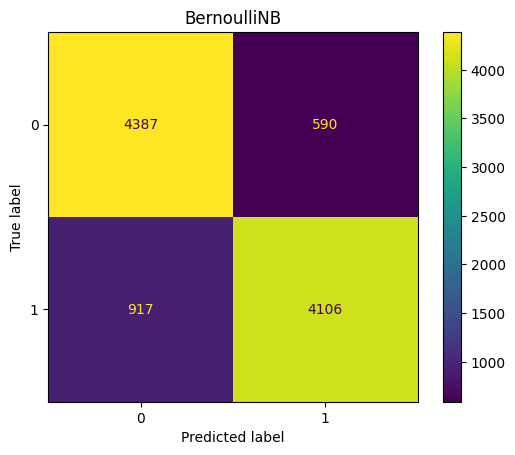

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

k = [CNB, MNB, BNB]

for model in k:
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(type(model).__name__)
    plt.show()


0.9242863979001796 0.9242864979022957 0.9234220796112046


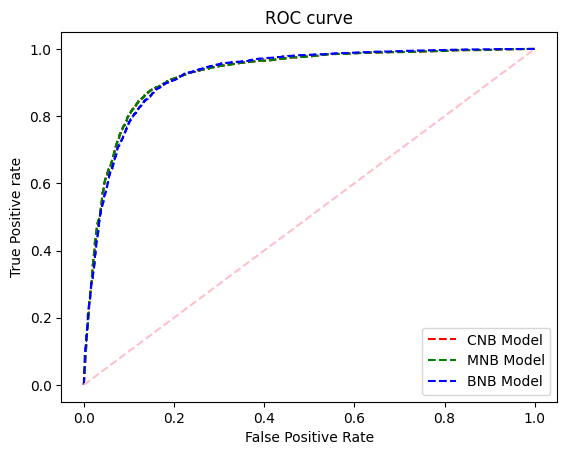

In [29]:
from sklearn.metrics import roc_curve

# Membandingkan performa CNB (ComplementNB), MNB (MultinomialNB), dan BNB (BernoulliNB) menggunakan ROC Curve dan AUC Score
CNB_prob = CNB.predict_proba(X_test)
MNB_prob = MNB.predict_proba(X_test)
BNB_prob = BNB.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, CNB_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, MNB_prob[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, BNB_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
from sklearn.metrics import roc_auc_score
auc_CNB = roc_auc_score(y_test, CNB_prob[:,1])
auc_MNB = roc_auc_score(y_test, MNB_prob[:,1])
auc_BNB = roc_auc_score(y_test, BNB_prob[:,1])
print(auc_CNB, auc_MNB,auc_BNB)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='CNB Model')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='MNB Model')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='BNB Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='pink')


plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Mencoba menggunakan n-diagram yang berbeda

##### 1. Bigram: ngram_range = (2,2)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv_twograms = CountVectorizer(stop_words='english',ngram_range = (2,2),tokenizer = token.tokenize)
text_counts_twograms = cv_twograms.fit_transform(nb['review'])

X_train, X_test, y_train, y_test = train_test_split(text_counts_twograms, nb['sentiment'], test_size=0.20,random_state=30)

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)
print('model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')

model accuracy is 86.78%


##### 2. Trigram: ngram_range= (3,3)

In [31]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv_threegrams = CountVectorizer(stop_words='english',ngram_range = (3,3),tokenizer = token.tokenize)
text_counts_threegrams = cv_threegrams.fit_transform(nb['review'])

X_train, X_test, y_train, y_test = train_test_split(text_counts_threegrams, nb['sentiment'], test_size=0.20,random_state=30)

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)
print('model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')

model accuracy is 69.44%


#### Term Frequency-Inverse Document Frequency

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
text_count_2 = tfidf.fit_transform(nb['review'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)

In [33]:
# Complement Naive Bayes model
CNB.fit(X_train, y_train)
accuracy_score_cnb = metrics.accuracy_score(CNB.predict(X_test), y_test)
print('accuracy_score_cnb = '+str('{:4.2f}'.format(accuracy_score_cnb*100))+'%')

accuracy_score_cnb = 86.21%


In [34]:
# Mutilnominal Naive Bayes model
MNB.fit(X_train, y_train)
accuracy_score_mnb = metrics.accuracy_score(MNB.predict(X_test), y_test)
print('accuracy_score_mnb = '+str('{:4.2f}'.format(accuracy_score_mnb*100))+'%')

accuracy_score_mnb = 86.20%


In [35]:
# Bernoulli Naive Bayes model
BNB.fit(X_train, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(X_test), y_test)
print('accuracy_score_bnb = '+str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')

accuracy_score_bnb = 84.93%


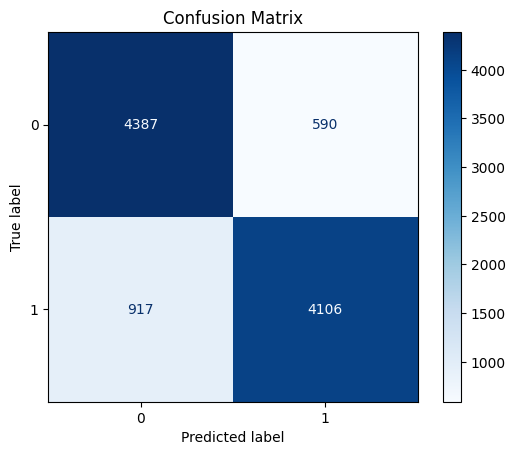

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      4977
           1       0.87      0.82      0.84      5023

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [36]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prediksi dari model
y_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
